# Fitting max-stable PCA to max-linear models

In [1]:
library(evd)
library(maxstablePCA)
library(dplyr)
library(GGally)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: ggplot2

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2



In [2]:
set.seed(1842024)
s <- 200

In [3]:
A1 <- matrix(
    c(
        6/10, 4 / 10, 1/10, 6 / 17, 6 / 18, 
        3 / 10, 4 / 10, 1 / 10, 3 / 17, 4 / 18, 
        1 / 10, 2 / 10, 8 / 10, 8 / 17, 8 / 18
     ), 
    5, 3
)

In [4]:
A1

0.6000000,0.3000000,0.1000000
0.4000000,0.4000000,0.2000000
0.1000000,0.1000000,0.8000000
0.3529412,0.1764706,0.4705882
0.3333333,0.2222222,0.4444444


In [5]:
Z1 <- matrix(rfrechet(30000), 10000, 3)
X1 <- t(maxmatmul(A1, t(Z1)))

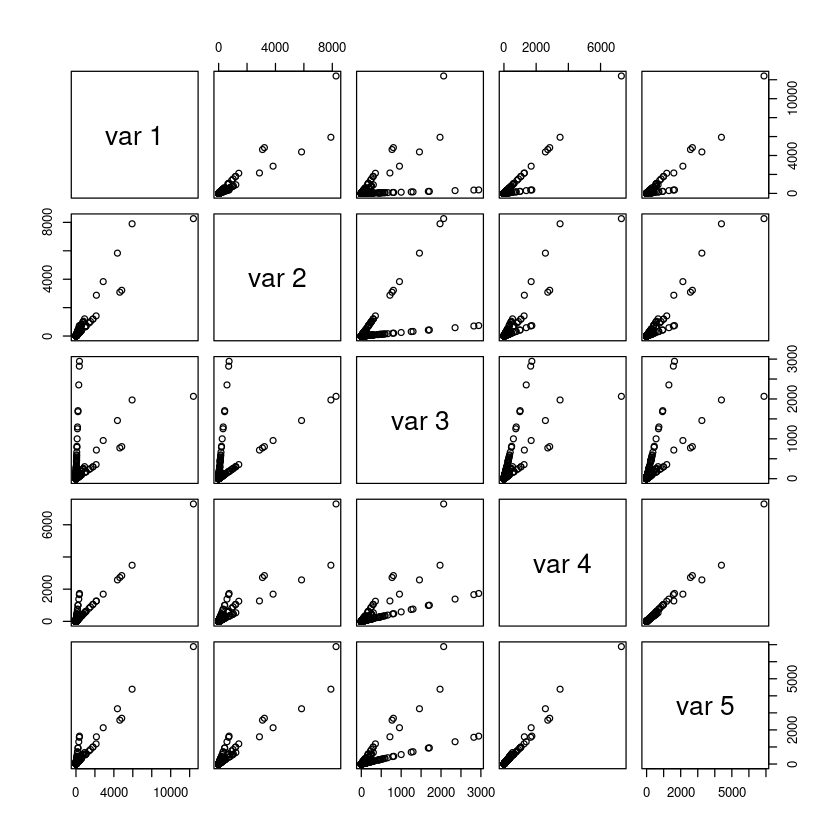

In [6]:
pairs(X1)

In [7]:
X1trafo <- transform_unitpareto(X1)

In [8]:
summary(rowSums(X1trafo))

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
    5.01     7.20    10.75    48.94    20.74 42500.00 

In [9]:
length(which(rowSums(X1trafo) > s))

[1] 255

In [10]:
maxPCAX1P1 <- max_stable_prcomp(X1trafo, p=1, s = s, n_initial_guesses = 2000)
maxPCAX1P2 <- max_stable_prcomp(X1trafo, p=2, s = s, n_initial_guesses = 2000)
maxPCAX1P3 <- max_stable_prcomp(X1trafo, p=3, s = s, n_initial_guesses = 2000)
maxPCAX1P4 <- max_stable_prcomp(X1trafo, p=4, s = s, n_initial_guesses = 2000)

For consistency with the rest of the package the inequality sign may be switched from >= to <= in a future nloptr version.

For consistency with the rest of the package the inequality sign may be switched from >= to <= in a future nloptr version.

For consistency with the rest of the package the inequality sign may be switched from >= to <= in a future nloptr version.

For consistency with the rest of the package the inequality sign may be switched from >= to <= in a future nloptr version.



In [11]:
maxPCAX1P3

$p
[1] 3

$d
[1] 5

$decoder_matrix
            [,1]      [,2]      [,3]
[1,] 0.007232178 0.4162180 1.1937246
[2,] 0.056040948 1.2472226 0.6573421
[3,] 1.192405560 0.2707443 0.1975194
[4,] 0.779339154 0.3723520 0.7148724
[5,] 0.747177690 0.7174855 0.6806322

$encoder_matrix
           [,1]      [,2]        [,3]       [,4]       [,5]
[1,] 0.08324021 0.1589528 0.838645540 0.03559176 0.09947057
[2,] 0.40240223 0.8018115 0.041476779 0.18859698 0.23926667
[3,] 0.83771578 0.4004922 0.003683448 0.11042969 0.16222066

$reconstr_matrix
          [,1]      [,2]       [,3]       [,4]      [,5]
[1,] 1.0000019 0.4780774 0.01726338 0.13182263 0.1936468
[2,] 0.5506659 1.0000374 0.05173078 0.23522241 0.2984188
[3,] 0.1654651 0.2170859 1.00000561 0.05106156 0.1186093
[4,] 0.5988599 0.2985561 0.65358931 0.07894314 0.1159671
[5,] 0.5701764 0.5752882 0.62661724 0.13531560 0.1716704

$loss_fctn_value
[1] 0.1842764

$optim_conv_status
[1] 4

$s
[1] 200

$starting_vals
$starting_vals$encoder_matrix_x0
      

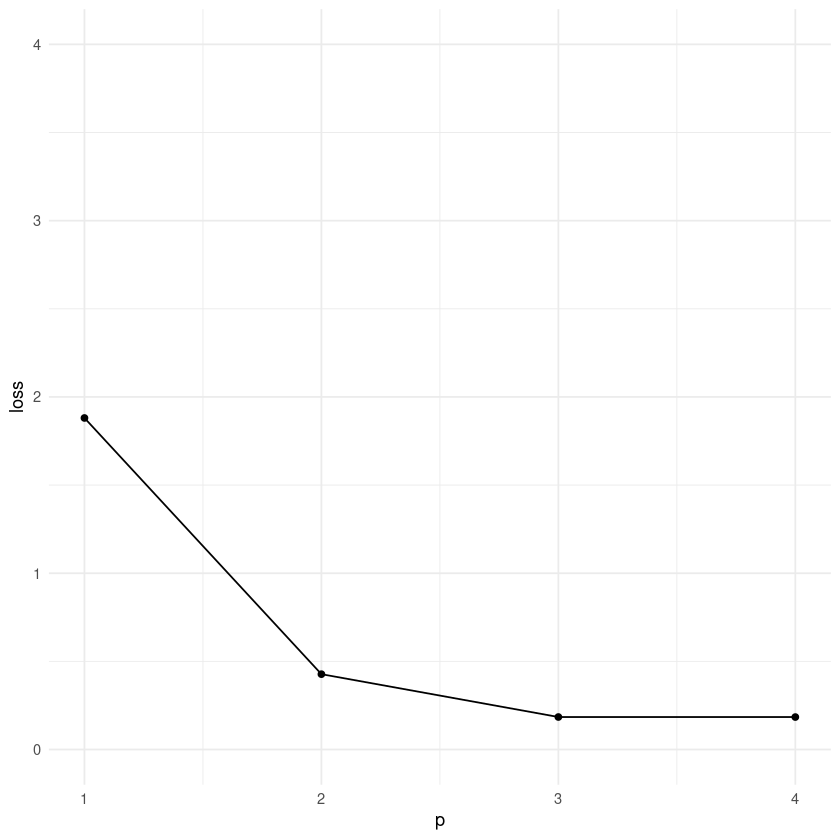

In [12]:
plotlossdatX1 <- data.frame(
    p = 1:4, 
    loss = c(
        maxPCAX1P1$loss_fctn_value,
        maxPCAX1P2$loss_fctn_value,
        maxPCAX1P3$loss_fctn_value,
        maxPCAX1P4$loss_fctn_value
    )
)

pe1 <- ggplot(aes(x = p, y = loss), data = plotlossdatX1) + geom_line() + geom_point() + ylim(0,4) + theme_minimal()
pe1

In [13]:
ggsave("mlm_lindep_elbow.png", pe1)

Saving 6.67 x 6.67 in image


In [14]:
rec1 <- t(maxmatmul(maxPCAX1P3$reconstr_matrix, t(X1)))

datX1 <- data.frame(X1)
datX1$is_rec = "original"
datrec1 <- data.frame(rec1)
datrec1$is_rec = "reconstruction"
names(datrec1) <- names(datX1)
plot_datX1 <- full_join(datX1, datrec1)

Joining with `by = join_by(X1, X2, X3, X4, X5, is_rec)`


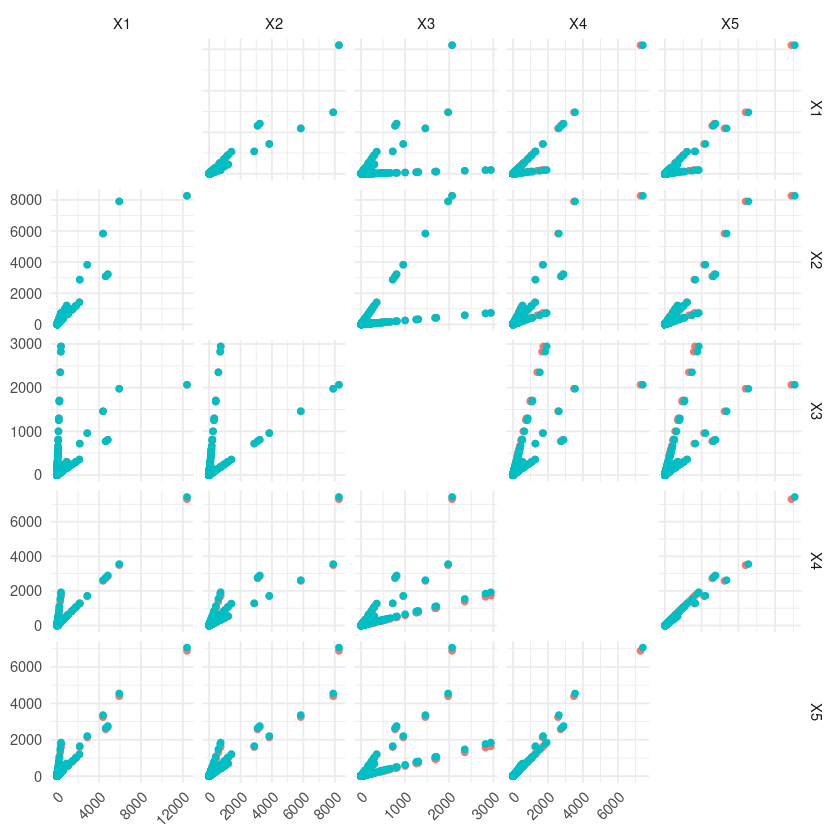

In [15]:
p1 <- ggpairs(
    plot_datX1, 
    aes(color = is_rec), 
    columns = 1:5,
    upper = list(continuous = "points", combo = "dot_no_facet"),
    diag = list(continuous = "blankDiag", discrete = "barDiag", na = "naDiag")
) + 
theme_minimal() +
theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))
p1

In [16]:
ggsave("mlm_lindep.png", p1)

Saving 6.67 x 6.67 in image


# Second matrix 

In [17]:
A2 <- matrix(
    c(
        2/3, 2/3, 0, 0, 1 / 5, 
        0, 1/3, 2/3, 1/3, 3 / 5, 
        1 / 3, 0, 1/3, 2/3, 1 / 5
     ), 
    5, 3
)

In [18]:
A2

0.6666667,0.0000000,0.3333333
0.6666667,0.3333333,0.0000000
0.0000000,0.6666667,0.3333333
0.0000000,0.3333333,0.6666667
0.2000000,0.6000000,0.2000000


In [19]:
Z2 <- matrix(rfrechet(30000), 10000, 3)
X2 <- t(maxmatmul(A2, t(Z2)))
X2trafo <- transform_unitpareto(X2)

In [20]:
length(which(rowSums(X2trafo) > s))

[1] 250

In [21]:
maxPCAX2P1 <- max_stable_prcomp(X2trafo, p=1, s = s, n_initial_guesses = 2000)
maxPCAX2P2 <- max_stable_prcomp(X2trafo, p=2, s = s, n_initial_guesses = 2000)
maxPCAX2P3 <- max_stable_prcomp(X2trafo, p=3, s = s, n_initial_guesses = 2000)
maxPCAX2P4 <- max_stable_prcomp(X2trafo, p=4, s = s, n_initial_guesses = 2000)

For consistency with the rest of the package the inequality sign may be switched from >= to <= in a future nloptr version.

For consistency with the rest of the package the inequality sign may be switched from >= to <= in a future nloptr version.

For consistency with the rest of the package the inequality sign may be switched from >= to <= in a future nloptr version.

For consistency with the rest of the package the inequality sign may be switched from >= to <= in a future nloptr version.



In [22]:
maxPCAX2P3

$p
[1] 3

$d
[1] 5

$decoder_matrix
            [,1]         [,2]         [,3]
[1,] 0.873815850 2.047131e-02 1.332774e+00
[2,] 0.001704978 8.179535e-18 1.912108e+00
[3,] 0.338249119 2.093719e+00 2.189551e-02
[4,] 1.564733250 9.592668e-03 3.451961e-19
[5,] 0.070385035 1.900156e+00 8.293208e-02

$encoder_matrix
             [,1]         [,2]         [,3]         [,4]         [,5]
[1,] 1.725981e-19 3.176345e-05 5.819669e-02 0.6390790768 0.0000000000
[2,] 9.832434e-02 2.867974e-02 1.403568e-01 0.1978983697 0.5262592421
[3,] 9.272831e-06 5.229835e-01 6.829687e-05 0.0002716247 0.0002346523

$reconstr_matrix
             [,1]         [,2]        [,3]        [,4]         [,5]
[1,] 2.012828e-03 0.6970187212 0.050853190 0.558437426 0.0107732153
[2,] 1.773065e-05 1.0000008083 0.000130591 0.001089616 0.0004486804
[3,] 2.058635e-01 0.0600473171 0.293867653 0.414343578 1.1018389772
[4,] 9.431928e-04 0.0002751152 0.091062296 0.999988281 0.0050482303
[5,] 1.868316e-01 0.0544959714 0.266699729 0.376037

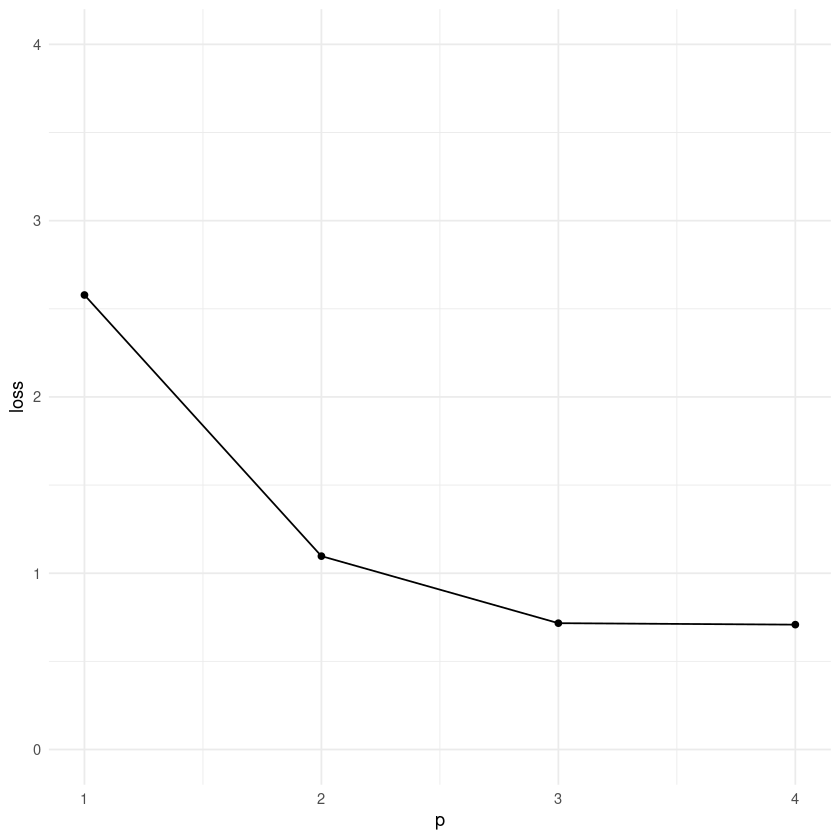

In [23]:
plotlossdatX2 <- data.frame(
    p = 1:4, 
    loss = c(
        maxPCAX2P1$loss_fctn_value,
        maxPCAX2P2$loss_fctn_value,
        maxPCAX2P3$loss_fctn_value,
        maxPCAX2P4$loss_fctn_value
    )
)

pe2 <- ggplot(aes(x = p, y = loss), data = plotlossdatX2) + geom_line() + geom_point() + ylim(0,4) + theme_minimal()
pe2

In [24]:
ggsave("mlm_nolindep_elbow.png", pe2)

Saving 6.67 x 6.67 in image


In [25]:
rec2 <- t(maxmatmul(maxPCAX2P3$reconstr_matrix, t(X2)))

datX2 <- data.frame(X2)
datX2$is_rec = "original"
datrec2 <- data.frame(rec2)
datrec2$is_rec = "reconstruction"
names(datrec2) <- names(datX2)
plot_datX2 <- full_join(datX2, datrec2)

Joining with `by = join_by(X1, X2, X3, X4, X5, is_rec)`


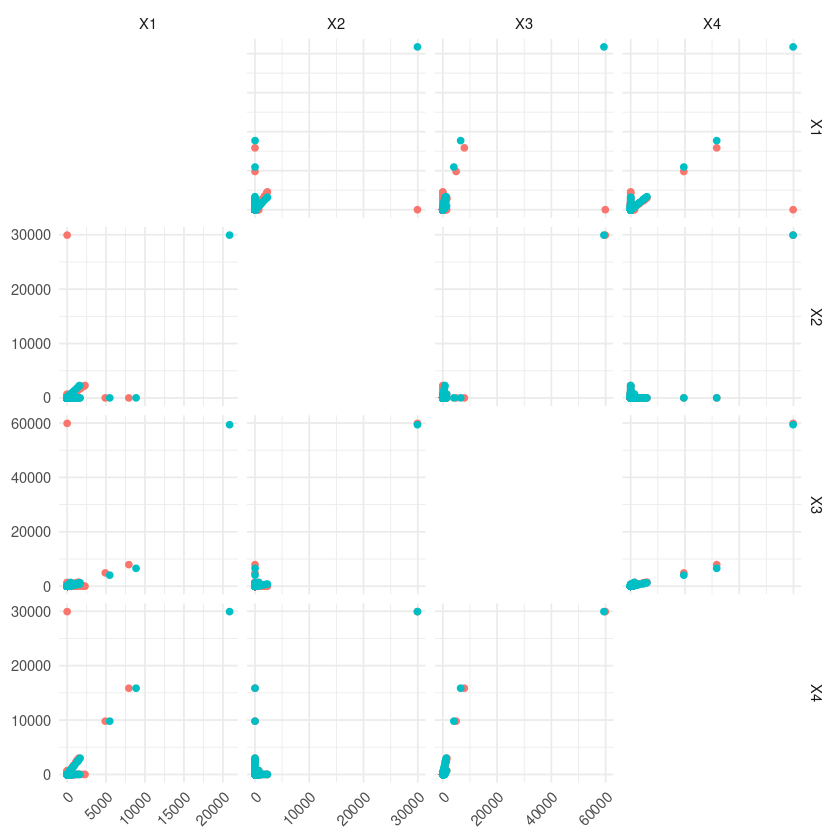

In [26]:
p2 <- ggpairs(
    plot_datX2, 
    aes(color = is_rec),
    columns = 1:4,
    upper = list(continuous = "points", combo = "dot_no_facet"),
    diag = list(continuous = "blankDiag", discrete = "barDiag", na = "naDiag")
) + 
theme_minimal() +
theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))

p2

In [27]:
ggsave("mlm_nolindep.png", p2)

Saving 6.67 x 6.67 in image
